In [2]:
import numpy as np
from collections import defaultdict

In [19]:
import numpy as np
from collections import defaultdict

class HDBSCAN:
    def __init__(self, min_samples=5, min_cluster_size=5):
        """
        min_samples: controls local density (like k in kNN)
        min_cluster_size: minimum size of a valid cluster
        """
        self.min_samples = min_samples
        self.min_cluster_size = min_cluster_size
        self.labels_ = None

    # -----------------------------
    # Step 1: Euclidean distance
    # -----------------------------
    def _euclidean_distance(self, p1, p2):
        return np.sqrt(np.sum((p1 - p2) ** 2))

    # -----------------------------
    # Step 2: Core distances
    # -----------------------------
    def _core_distances(self, X):
        n = X.shape[0]
        core_dist = np.zeros(n)
        for i in range(n):
            distances = [self._euclidean_distance(X[i], X[j])
                         for j in range(n) if i != j]
            distances.sort()
            core_dist[i] = distances[self.min_samples - 1]
        return core_dist

    # -----------------------------
    # Step 3: Mutual reachability
    # -----------------------------
    def _mutual_reachability(self, X, core_dist):
        n = X.shape[0]
        mr = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                if i == j:
                    mr[i][j] = 0
                else:
                    d = self._euclidean_distance(X[i], X[j])
                    mr[i][j] = max(core_dist[i], core_dist[j], d)
        return mr

    # -----------------------------
    # Step 4: Minimum Spanning Tree (Prim's)
    # -----------------------------
    def _minimum_spanning_tree(self, mr):
        n = mr.shape[0]
        visited = [False] * n
        visited[0] = True
        edges = []

        for _ in range(n - 1):
            min_edge = (None, None, float("inf"))
            for i in range(n):
                if visited[i]:
                    for j in range(n):
                        if not visited[j] and mr[i][j] < min_edge[2]:
                            min_edge = (i, j, mr[i][j])
            i, j, w = min_edge
            visited[j] = True
            edges.append((i, j, w))
        return edges

    # -----------------------------
    # Step 5: Extract clusters
    # -----------------------------
    def _extract_clusters(self, mst_edges, n_points):
        # Union-Find data structure
        parent = list(range(n_points))

        def find(x):
            while parent[x] != x:
                parent[x] = parent[parent[x]]  # path compression
                x = parent[x]
            return x

        def union(a, b):
            ra, rb = find(a), find(b)
            if ra != rb:
                parent[rb] = ra

        # Remove edges starting from largest weight
        mst_edges.sort(key=lambda x: x[2], reverse=True)
        for i, j, _ in mst_edges:
            union(i, j)

        # Collect clusters
        clusters = defaultdict(list)
        for i in range(n_points):
            clusters[find(i)].append(i)

        # Filter clusters by min_cluster_size
        filtered_clusters = [c for c in clusters.values()
                             if len(c) >= self.min_cluster_size]

        return filtered_clusters

    # -----------------------------
    # Step 6: Fit method
    # -----------------------------
    def fit(self, X):
        X = np.array(X)
        n = X.shape[0]

        # 1. Core distances
        core_dist = self._core_distances(X)

        # 2. Mutual reachability
        mr = self._mutual_reachability(X, core_dist)

        # 3. MST
        mst_edges = self._minimum_spanning_tree(mr)

        # 4. Extract clusters
        clusters = self._extract_clusters(mst_edges, n)

        # 5. Label points
        labels = -1 * np.ones(n, dtype=int)
        for cluster_id, cluster in enumerate(clusters):
            for idx in cluster:
                labels[idx] = cluster_id

        self.labels_ = labels
        return self

    # -----------------------------
    # Step 7: Fit + Predict
    # -----------------------------
    def fit_predict(self, X):
        self.fit(X)
        return self.labels_


In [20]:
from sklearn.datasets import make_blobs

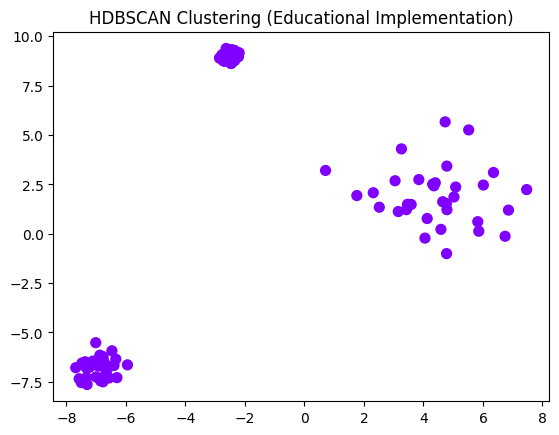

Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [22]:
import matplotlib.pyplot as plt

# Create toy dataset
X, _ = make_blobs(n_samples=100, centers=3, cluster_std=[0.2, 1.5, 0.5], random_state=42)

# Fit HDBSCAN
model = HDBSCAN(min_samples=5, min_cluster_size=5)
labels = model.fit_predict(X)

# Plot clusters
plt.scatter(X[:,0], X[:,1], c=labels, cmap='rainbow', s=50)
plt.title("HDBSCAN Clustering (Educational Implementation)")
plt.show()

print("Labels:", labels)
